In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
from tqdm import tqdm
import seaborn as sns

from scipy.spatial.distance import pdist, squareform

from graspy.plot import heatmap

from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.mgc import MGC
from mgcpy.benchmarks.simulations import quad_sim, circle_sim, linear_sim

from simulations import rho_ER_marg, rho_sbm_marg, rho_sbm_diff_block
from utils import sbm_params, dcorr_power, pearson_power, identity, block_permute, sort_graph, to_distance_mtx, to_kernel, estimate_block_assignment

In [3]:
P1 = sbm_params(a=0.7, b=0.3)
P2 = sbm_params(a=0.2, b=0.5)
A, B = rho_sbm_marg(rho=-0.1, AL=P1, BL=P2, k=2, n=100)

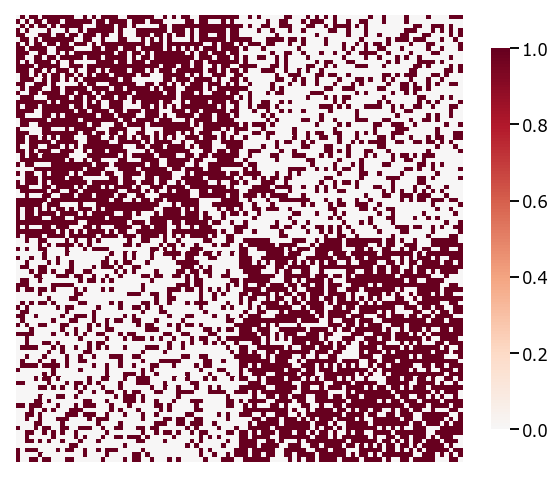

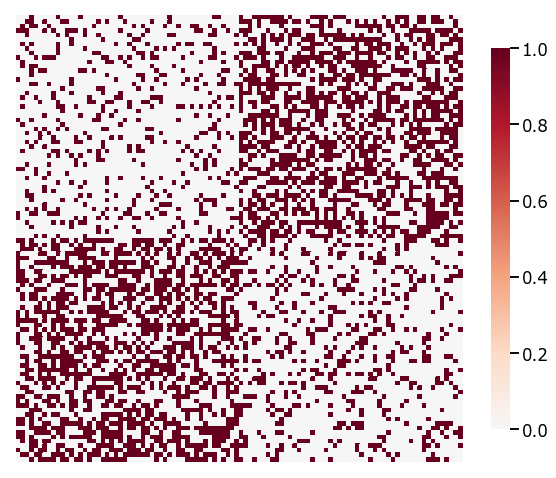

In [4]:
heatmap(A)
heatmap(B)

In [15]:
def power(indept_test, sim_func, mc=500, alpha=0.05,
                given_blocks=False, blocks=None, **kwargs):
    # power for any test that builds on distance matrices
    # can use dcorr / mgc
    test_stat_null_array = np.zeros(mc)
    test_stat_alt_array = np.zeros(mc)
    for i in range(mc):
        A, B = sim_func(**kwargs)
        if given_blocks:
            block_assignment = blocks
        else:
            block_assignment = estimate_block_assignment(A, B)
        A_null = block_permute(A, block_assignment)
        B_sorted = sort_graph(B, block_assignment)

        test_stat_alt, _ = indept_test.test_statistic(
            matrix_X=to_distance_mtx(A),
            matrix_Y=to_distance_mtx(B))
        test_stat_null, _ = indept_test.test_statistic(
            matrix_X=to_distance_mtx(A_null),
            matrix_Y=to_distance_mtx(B_sorted))

        test_stat_alt_array[i] = test_stat_alt
        test_stat_null_array[i] = test_stat_null
    test_stat_null_array = np.absolute(test_stat_null_array)
    test_stat_alt_array = np.absolute(test_stat_alt_array)
    critical_value = np.sort(test_stat_null_array)[math.ceil((1-alpha)*mc)]
    power = np.where(test_stat_alt_array > critical_value)[0].shape[0] / mc
    return power

In [6]:
%%time
n_arr = np.linspace(10, 100, 10, dtype=int)
rho_arr = np.array([-0.1])
k = 2
P1 = sbm_params(a=0.7, b=0.3)
P2 = sbm_params(a=0.2, b=0.5)
nmc = 500
test_names = ['dcorr']
power_sbm = {
    'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'mgc': np.zeros((rho_arr.shape[0], n_arr.shape[0]))
}

for name in test_names:
    for i, rho in enumerate(rho_arr):
        for j, n in enumerate(n_arr):
            blocks = np.repeat(np.arange(k), n//k)
            if name == 'pearson':
                test = RVCorr(which_test='pearson')
                test_power = pearson_power(test, rho_sbm_marg, given_blocks=True, blocks=blocks,
                                           rho=rho, AL=P1, BL=P2, k=k, n=n, mc=nmc)
            elif name == 'dcorr':
                test = DCorr(compute_distance_matrix=identity)
                test_power = power(test, rho_sbm_marg, given_blocks=True, blocks=blocks,
                                         rho=rho, AL=P1, BL=P2, k=k, n=n, mc=nmc)
            elif name == 'mgc':
                test = MGC(compute_distance_matrix=identity)
                test_power = power(test, rho_sbm_marg, given_blocks=True, blocks=blocks,
                                         rho=rho, AL=P1, BL=P2, k=k, n=n, mc=nmc)
            power_sbm[name][i, j] = test_power
            print('finish {} for rho={}, n={}'.format(name, rho, n))

finish dcorr for rho=-0.1, n=10
finish dcorr for rho=-0.1, n=20
finish dcorr for rho=-0.1, n=30
finish dcorr for rho=-0.1, n=40
finish dcorr for rho=-0.1, n=50
finish dcorr for rho=-0.1, n=60
finish dcorr for rho=-0.1, n=70
finish dcorr for rho=-0.1, n=80
finish dcorr for rho=-0.1, n=90
finish dcorr for rho=-0.1, n=100
CPU times: user 55.1 s, sys: 480 ms, total: 55.5 s
Wall time: 56.7 s


In [7]:
power_sbm

{'pearson': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 'dcorr': array([[0.096, 0.308, 0.514, 0.806, 0.922, 0.984, 0.992, 0.996, 1.   ,
         1.   ]]),
 'mgc': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])}